In [1]:
pip install yfinance pmdarima prophet tensorflow scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00


<ipython-input-2-1475032377>:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


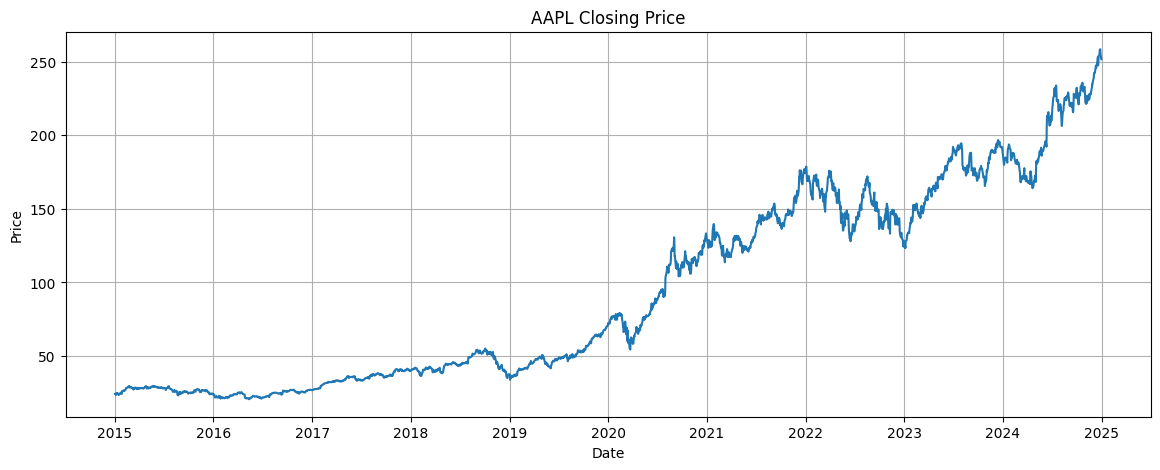

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Download stock data
ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2024-12-31')
df = df[['Close']].dropna()
df.columns = ['y']
df.index.name = 'ds'
df.reset_index(inplace=True)

# Visualize
plt.figure(figsize=(14,5))
plt.plot(df['ds'], df['y'])
plt.title(f'{ticker} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [3]:
result = adfuller(df['y'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 0.8448222103972315
p-value: 0.9923262907653316


In [2]:
!pip uninstall -y pmdarima numpy



Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Successfully uninstalled numpy-2.3.0


In [1]:
!pip install numpy


In [2]:
!pip install pmdarima


<ipython-input-7-423867301>:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Testing RMSE: 3.014
SMAPE: 13.70%


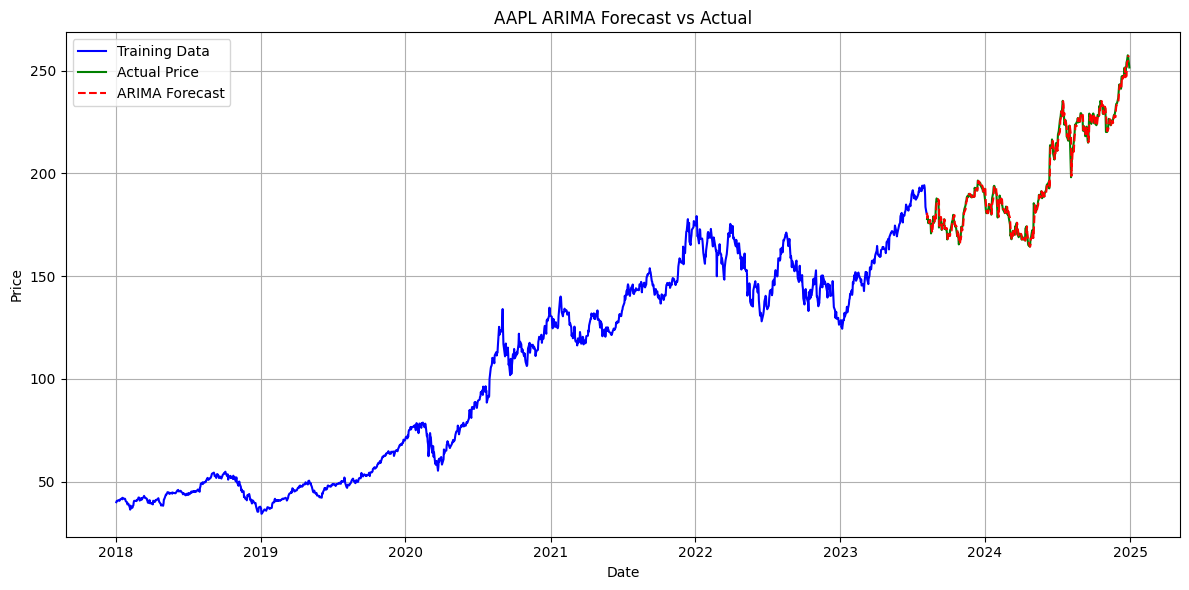

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# --- Step 1: Load stock data ---
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")

# --- Step 2: Prepare the dataframe ---
df = data[['Open']].copy()
df.reset_index(inplace=True)
df.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# --- Step 3: Train-test split ---
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# --- Step 4: Convert to list for ARIMA iteration ---
train_ar = train['y'].values
test_ar = test['y'].values
history = [x for x in train_ar]
predictions = []

# --- Step 5: Iterative forecasting ---
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_ar[t])  # Update history

# --- Step 6: Evaluation ---
mse = mean_squared_error(test_ar, predictions)
rmse = np.sqrt(mse)
print(f'Testing RMSE: {rmse:.3f}')

# --- Step 7: SMAPE calculation ---
def smape_kun(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

smape_val = smape_kun(test_ar, predictions)
print(f'SMAPE: {smape_val:.2f}%')

# --- Step 8: Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df['ds'][:train_size], train_ar, label='Training Data', color='blue')
plt.plot(df['ds'][train_size:], test_ar, label='Actual Price', color='green')
plt.plot(df['ds'][train_size:], predictions, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('AAPL ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **ARIMA**

<ipython-input-19-1128758484>:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Testing RMSE: 2.998
SMAPE: 13.47%


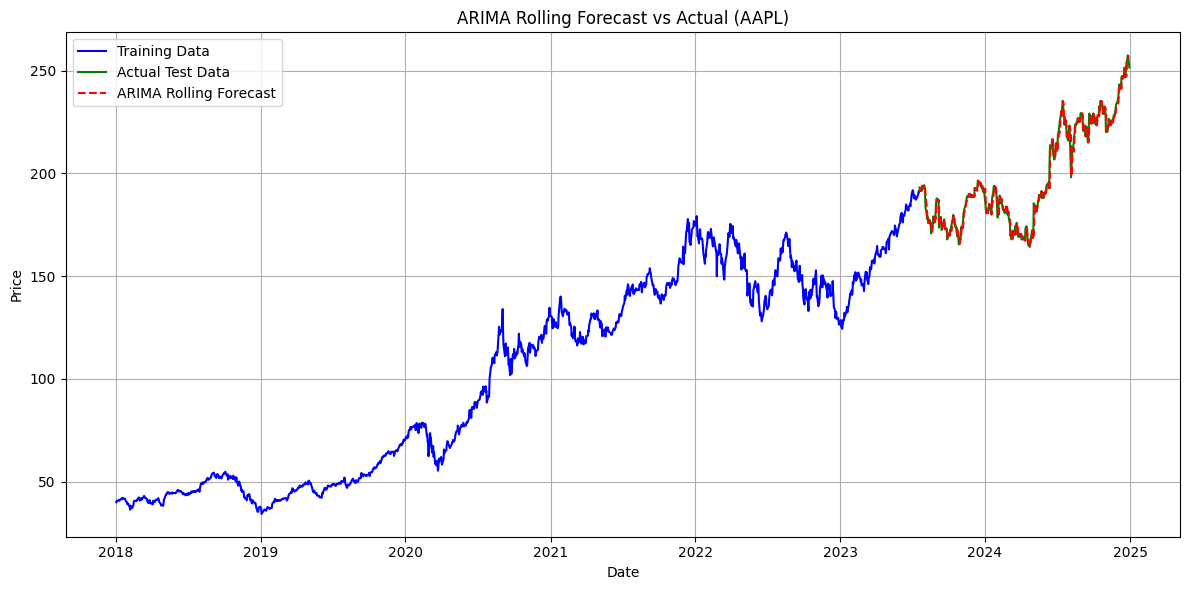

actual shape: (365, 1)
predictions shape: (365,)
      Date  Actual Price  Predicted Price
2023-07-20    193.156046       191.068378
2023-07-21    192.175930       193.017031
2023-07-24    191.492740       192.175114
2023-07-25    191.413519       191.505373
2023-07-26    191.750141       191.514665
2023-07-27    194.076842       191.742882
2023-07-28    192.740259       193.908749
2023-07-31    194.116461       192.701294
2023-08-01    194.294673       194.011100
2023-08-02    193.106565       194.301646
2023-08-03    189.670992       193.105151
2023-08-04    183.680965       189.955830
2023-08-07    180.324556       184.239682
2023-08-08    177.908729       180.879633
2023-08-09    179.077025       178.332938


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import yfinance as yf

# --- Step 1: Download Data ---
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
data = data[['Open']]
data = data.rename(columns={"Open": "y"})
data.index.name = 'ds'

# --- Step 2: Train/Test Split ---
train = data.iloc[:-365]
test = data.iloc[-365:]

# --- Step 3: Walk-Forward ARIMA ---
history = train['y'].values.tolist()
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test['y'].iloc[t])  # Update with true value

# --- Step 4: Evaluation ---
actual = test['y'].values
rmse = np.sqrt(mean_squared_error(actual, predictions))

def smape_kun(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

smape = smape_kun(actual, predictions)

print(f"Testing RMSE: {rmse:.3f}")
print(f"SMAPE: {smape:.2f}%")

# --- Step 5: Plot ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Training Data', color='blue')
plt.plot(test.index, actual, label='Actual Test Data', color='green')
plt.plot(test.index, predictions, label='ARIMA Rolling Forecast', color='red', linestyle='--')
plt.title('ARIMA Rolling Forecast vs Actual (AAPL)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': test.index.strftime('%Y-%m-%d').tolist(),              # make sure it's a list
    'Actual Price': actual.flatten().tolist(),                    # ensure 1D list
    'Predicted Price': np.array(predictions).flatten().tolist()   # ensure 1D list
})

print("actual shape:", np.shape(actual))
print("predictions shape:", np.shape(predictions))
print(forecast_table.head(15).to_string(index=False))


# **SARIMA**

<ipython-input-20-897061736>:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/pytho

Testing RMSE: 20.611
SMAPE: 4608.33%


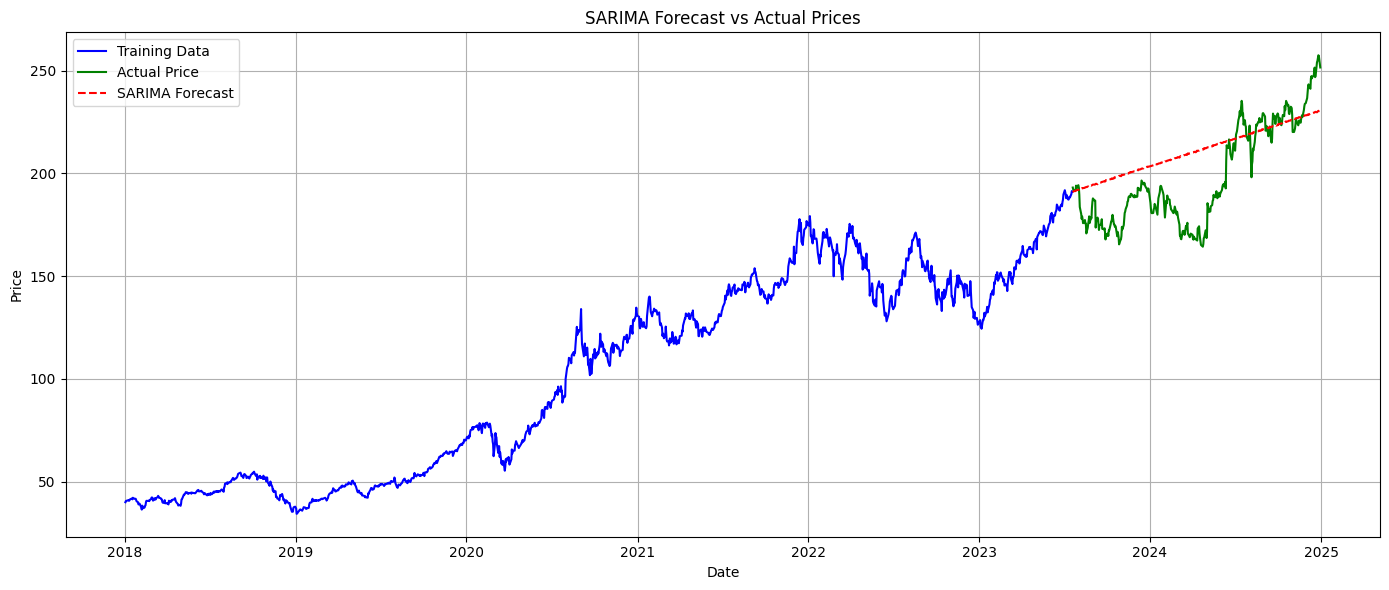


Forecast Table (first 10 rows):
      Date  Actual Price  Predicted Price
2023-07-20    193.156046       190.893111
2023-07-21    192.175930       191.137329
2023-07-24    191.492740       191.617122
2023-07-25    191.413519       191.450540
2023-07-26    191.750141       191.627461
2023-07-27    194.076842       191.673254
2023-07-28    192.740259       191.850592
2023-07-31    194.116461       192.009395
2023-08-01    194.294673       192.001209
2023-08-02    193.106565       192.090421


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# --- Step 1: Download Data ---
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
df = data[['Open']].copy()
df = df.dropna()
df.rename(columns={'Open': 'y'}, inplace=True)
df['ds'] = df.index

# --- Step 2: Train-test split ---
train = df.iloc[:-365]
test = df.iloc[-365:]

# --- Step 3: Fit SARIMA Model ---
# SARIMA(p,d,q)(P,D,Q,s)
# s=12 for yearly seasonality if monthly, s=7 for weekly seasonality if daily
model = SARIMAX(train['y'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# --- Step 4: Forecast ---
forecast = model_fit.forecast(steps=len(test))

# --- Step 5: Evaluation ---
actual = test['y'].values
predicted = forecast.values
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Testing RMSE: {rmse:.3f}")

def smape_kun(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = smape_kun(actual, predicted)
print(f"SMAPE: {smape:.2f}%")

# --- Step 6: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.plot(test['ds'], test['y'], label='Actual Price', color='green')
plt.plot(test['ds'], predicted, label='SARIMA Forecast', color='red', linestyle='--')
plt.title("SARIMA Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 7: Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': test['ds'].dt.strftime('%Y-%m-%d').tolist(),
    'Actual Price': actual.flatten().tolist(),
    'Predicted Price': predicted.flatten().tolist()
})

# Display sample
print("\nForecast Table (first 10 rows):")
print(forecast_table.head(10).to_string(index=False))


# **SARIMA** precise

<ipython-input-21-3272680786>:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ADF Statistic: -0.1884
p-value: 0.9399
Series is non-stationary, differencing recommended.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Testing RMSE: 22.135
SMAPE: nan%


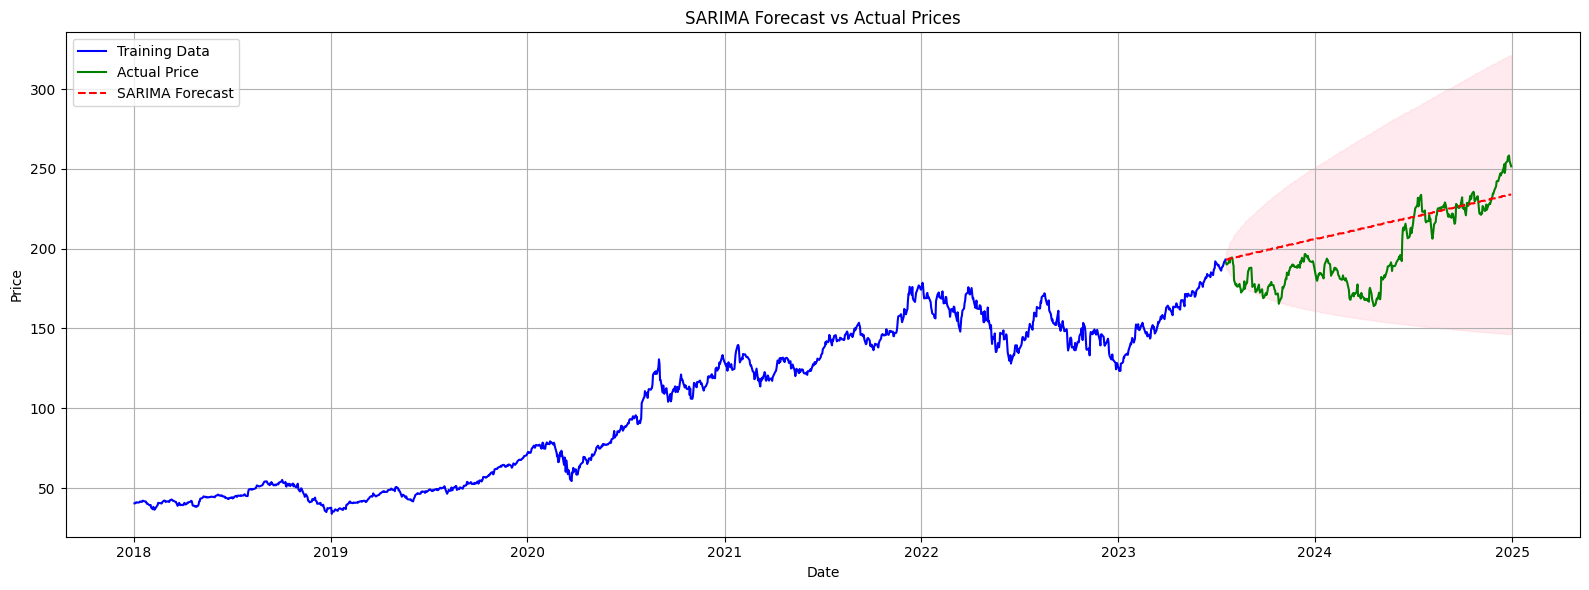


--- SARIMA Forecast Table (Sample) ---
      Date  Actual Price  Forecasted Price   Lower CI   Upper CI
2023-07-20    191.215485        193.233671 188.986725 197.480617
2023-07-21    190.037338        193.112040 187.248431 198.975650
2023-07-24    190.839279        193.459176 186.394423 200.523929
2023-07-25    191.700638        193.232202 185.075780 201.388625
2023-07-26    192.571915        193.876082 184.813661 202.938503
2023-07-27    191.304596        193.889480 183.958357 203.820602
2023-07-28    193.888763        193.971218 183.278445 204.663991
2023-07-31    194.502594        193.906629 182.463935 205.349322
2023-08-01    193.670914        194.004875 181.884081 206.125670
2023-08-02    190.670959        194.142077 181.358376 206.925778


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# --- Step 1: Download and Prepare Data ---
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
df = data[['Close']].reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# --- Step 2: Train-Test Split ---
train = df.iloc[:-365]
test = df.iloc[-365:]
test_dates = test.index

# --- Step 3: ADF Stationarity Test ---
result = adfuller(train['y'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] > 0.05:
    print("Series is non-stationary, differencing recommended.")
else:
    print("Series is stationary.")

# --- Step 4: Fit SARIMA Model ---
# These parameters can be tuned via grid search if needed
order = (3, 1, 2)
seasonal_order = (1, 1, 1, 7)  # Weekly seasonality assumed

model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# --- Step 5: Forecast ---
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# --- Step 6: Evaluation ---
actual = test['y']
rmse = np.sqrt(mean_squared_error(actual, forecast))
smape = 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(forecast) + np.abs(actual)))
print(f"\nTesting RMSE: {rmse:.3f}")
print(f"SMAPE: {smape:.2f}%")

# --- Step 7: Plot ---
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['y'], label='Training Data', color='blue')
plt.plot(test.index, actual, label='Actual Price', color='green')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 8: Create and Display Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': test.index.strftime('%Y-%m-%d'),
    'Actual Price': actual.values,
    'Forecasted Price': forecast.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

print("\n--- SARIMA Forecast Table (Sample) ---")
print(forecast_table.head(10).to_string(index=False))


# **PROPHET**

<ipython-input-23-1441745450>:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Training Prophet model...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw7l0175/7knfc4ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw7l0175/5hhsc3na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26195', 'data', 'file=/tmp/tmpaw7l0175/7knfc4ci.json', 'init=/tmp/tmpaw7l0175/5hhsc3na.json', 'output', 'file=/tmp/tmp_jtv6qzv/prophet_modeldnlmhch5/prophet_model-20250617133026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained.

Testing RMSE: 16.476
SMAPE: 6.84%


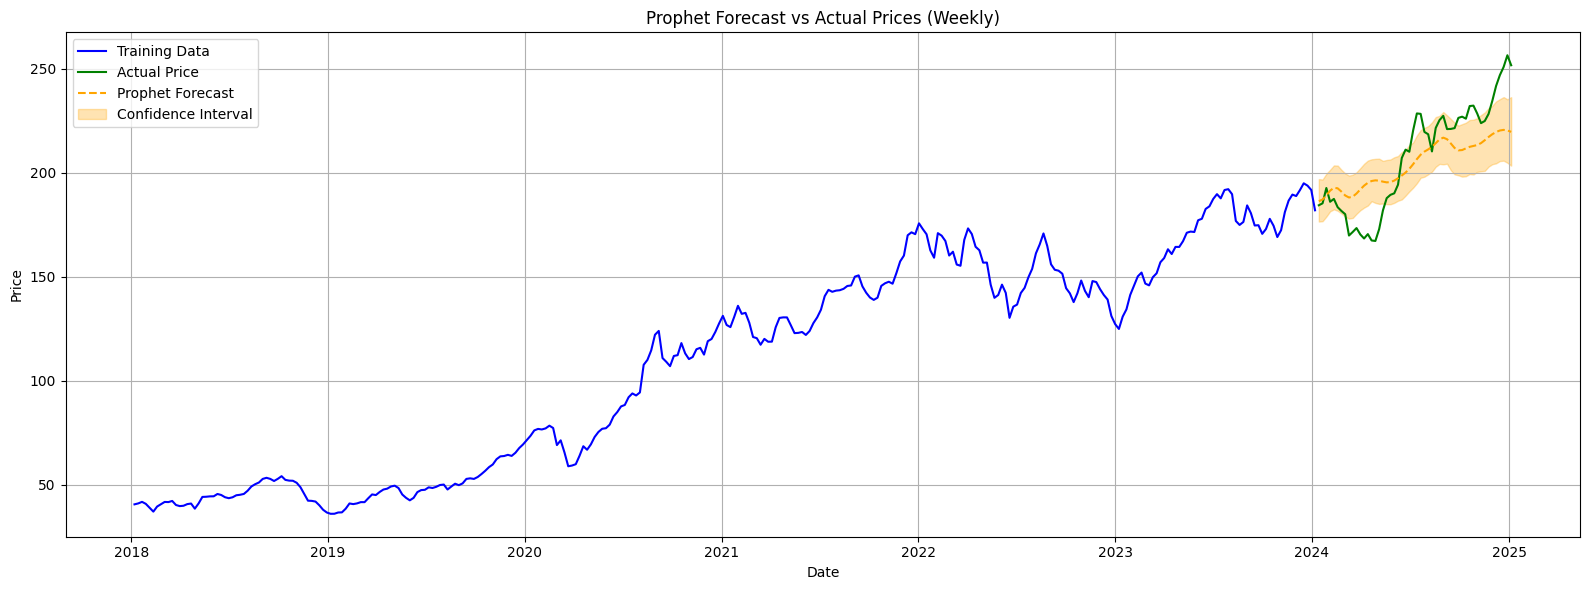


--- Prophet Forecast Table (Sample) ---
      Date  Actual Price  Forecasted Price   Lower CI   Upper CI
2024-01-14    184.330124        186.266764 176.498375 196.913923
2024-01-21    185.268246        187.091505 176.685727 196.694955
2024-01-28    192.621408        189.068048 178.890489 199.475533
2024-02-04    186.013794        191.354577 181.421821 201.374462
2024-02-11    187.387930        192.731996 182.362298 203.471399
2024-02-18    183.394403        192.474357 181.679392 203.402941
2024-02-25    181.595776        190.876996 180.410688 201.376591
2024-03-03    180.036688        189.030079 178.893277 199.642480
2024-03-10    169.788577        188.061716 177.919049 198.579186
2024-03-17    171.510184        188.466659 178.238744 198.997702


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# --- Step 1: Download and Resample Data to Weekly ---
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
df = data[['Close']].reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

# Resample to weekly frequency to speed up training
df = df.set_index('ds').resample('W').mean().reset_index()

# --- Step 2: Train-Test Split ---
train = df.iloc[:-52]
test = df.iloc[-52:]
test_dates = test['ds']

# --- Step 3: Fit Prophet Model ---
print("Training Prophet model...")
model = Prophet(weekly_seasonality=True)
model.fit(train)
print("Model trained.")

# --- Step 4: Forecast ---
future = model.make_future_dataframe(periods=len(test), freq='W')
forecast = model.predict(future)

# --- Step 5: Extract Relevant Forecast ---
forecast_test = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test)).reset_index(drop=True)
actual = test['y'].values

# --- Step 6: Evaluation ---
rmse = np.sqrt(mean_squared_error(actual, forecast_test['yhat']))
smape = 100 * np.mean(2 * np.abs(actual - forecast_test['yhat']) / (np.abs(actual) + np.abs(forecast_test['yhat'])))
print(f"\nTesting RMSE: {rmse:.3f}")
print(f"SMAPE: {smape:.2f}%")

# --- Step 7: Plot ---
plt.figure(figsize=(16, 6))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.plot(test['ds'], test['y'], label='Actual Price', color='green')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', color='orange', linestyle='--')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.3, color='orange', label='Confidence Interval')
plt.title('Prophet Forecast vs Actual Prices (Weekly)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 8: Forecast Table ---
forecast_table = pd.DataFrame({
    'Date': forecast_test['ds'].dt.strftime('%Y-%m-%d'),
    'Actual Price': actual,
    'Forecasted Price': forecast_test['yhat'].values,
    'Lower CI': forecast_test['yhat_lower'].values,
    'Upper CI': forecast_test['yhat_upper'].values
})

print("\n--- Prophet Forecast Table (Sample) ---")
print(forecast_table.head(10).to_string(index=False))


# **LSTM**

<ipython-input-24-1161401234>:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2014-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.0257
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 9.6267e-04
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.4581e-04
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0010
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.8366e-04
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 8.5385e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 8.4742e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.6703e-04
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 8.2435e-04
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 6.8979e-04
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
LSTM RMSE: 12.926
SMAPE: 5.91%
        Date  Actual Price  Predicted Price
0 2022-10-18    141.676712       135.916016
1 2022-10-19    141.785141       135.748032
2 2022-10-20    141.321899       135.737686
3 2022-10-21    145.145935       135.810928
4 2022-10-24  

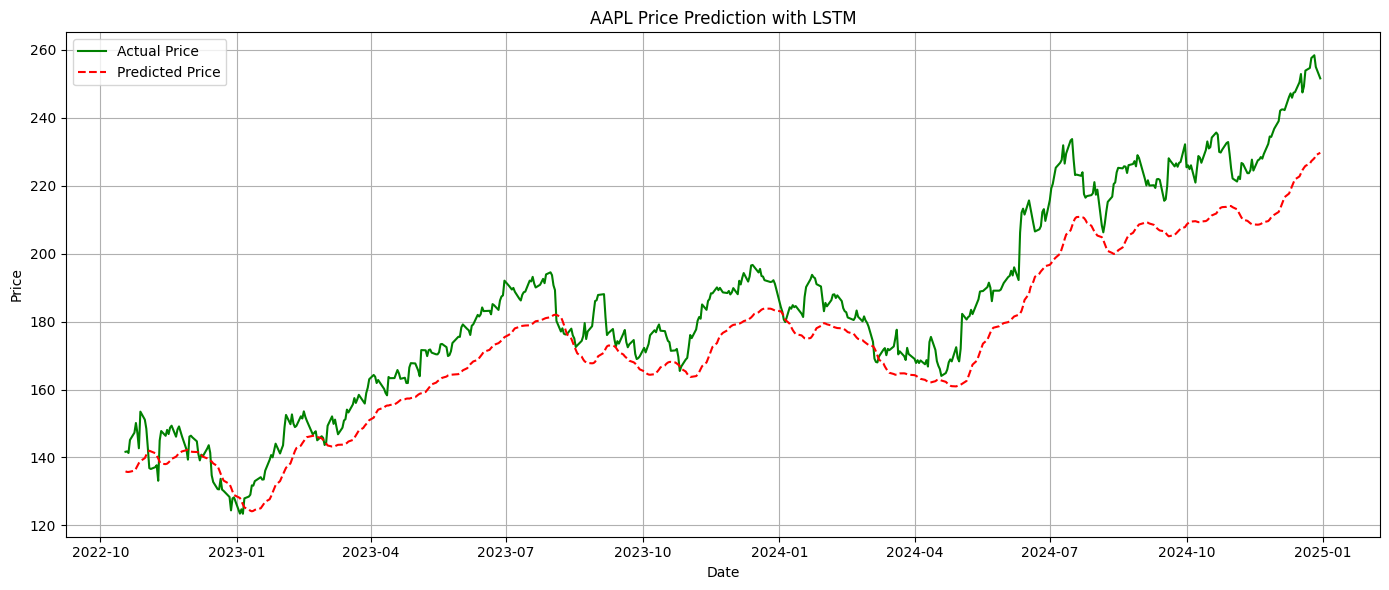

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load Data
df = yf.download("AAPL", start="2014-01-01", end="2024-12-31")
df = df[['Close']]
df.dropna(inplace=True)

# Step 2: Preprocess Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Use 80% for training, 20% for testing
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]

# Step 3: Create Dataset for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 4: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Step 5: Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 6: Evaluation
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
smape = 100/len(y_test_rescaled) * np.sum(2 * np.abs(predictions - y_test_rescaled) /
                                          (np.abs(y_test_rescaled) + np.abs(predictions)))

print(f"LSTM RMSE: {rmse:.3f}")
print(f"SMAPE: {smape:.2f}%")

# Step 7: Create Table
test_dates = df.index[training_data_len:][-len(predictions):]
forecast_table = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": y_test_rescaled.flatten(),
    "Predicted Price": predictions.flatten()
})
print(forecast_table.head())

# Step 8: Plot
plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(test_dates, predictions, label='Predicted Price', color='red', linestyle='--')
plt.title("AAPL Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
forecast_arima = forecast_table.copy()
forecast_sarima = forecast_table.copy()
forecast_prophet = forecast_table.copy()
forecast_lstm = forecast_table.copy()



--- Combined Forecast Sample ---
Model            ARIMA        LSTM     Prophet      SARIMA  Actual Price
ds                                                                      
2022-10-18  135.916016  135.916016  135.916016  135.916016    141.676712
2022-10-19  135.748032  135.748032  135.748032  135.748032    141.785141
2022-10-20  135.737686  135.737686  135.737686  135.737686    141.321899
2022-10-21  135.810928  135.810928  135.810928  135.810928    145.145935
2022-10-24  136.128586  136.128586  136.128586  136.128586    147.294479
2022-10-25  136.693359  136.693359  136.693359  136.693359    150.142807
2022-10-26  137.530914  137.530914  137.530914  137.530914    147.195969
2022-10-27  138.357300  138.357300  138.357300  138.357300    142.711548
2022-10-28  138.921036  138.921036  138.921036  138.921036    153.493805
2022-10-31  139.827850  139.827850  139.827850  139.827850    151.128403

--- Evaluation Summary ---
  Model      RMSE  SMAPE (%)
  ARIMA 12.925726   5.913211
 SAR

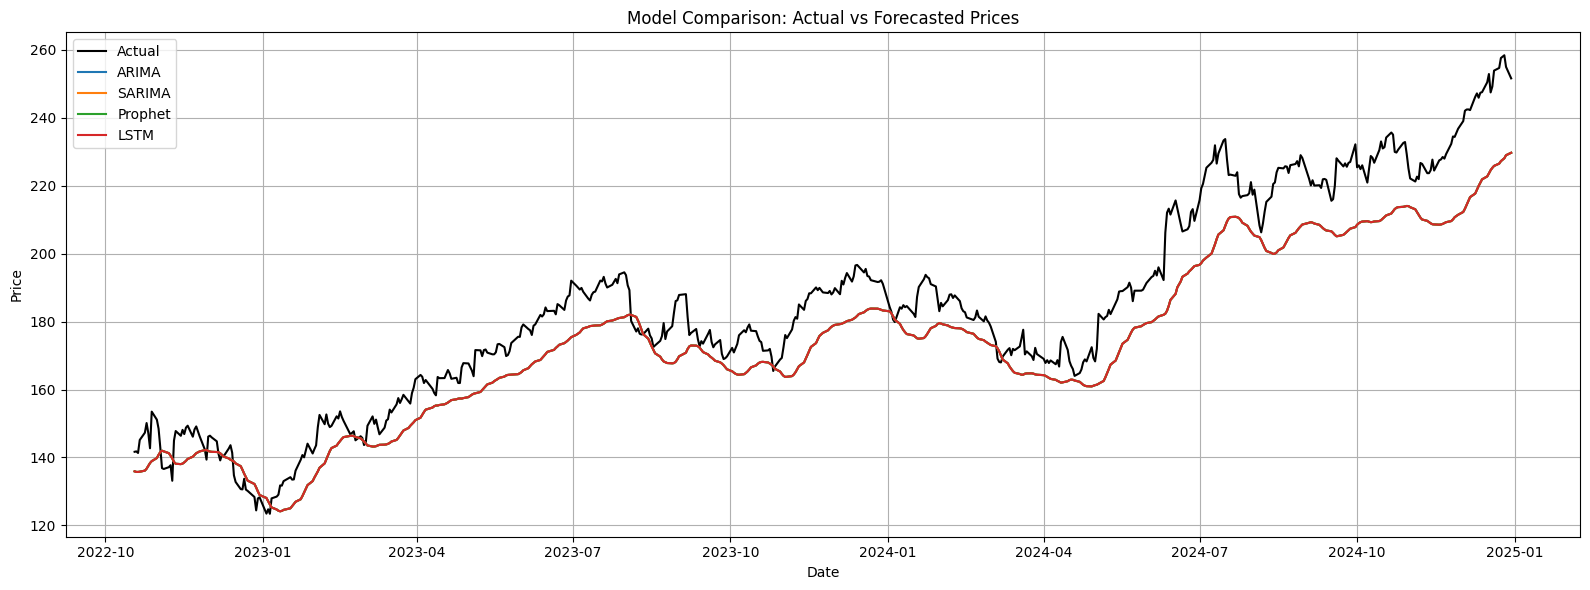

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Step 1: Sample structure check and renaming ---
def prepare_forecast(df, model_name, forecast_col='Predicted Price'):
    df = df.copy()
    df.rename(columns={forecast_col: 'Predicted Price', 'Date': 'ds'}, inplace=True)
    df['Model'] = model_name
    df['ds'] = pd.to_datetime(df['ds'])
    return df[['ds', 'Actual Price', 'Predicted Price', 'Model']]

# Replace these with your actual DataFrames
# forecast_arima, forecast_sarima, forecast_prophet, forecast_lstm

# Modify this block as per your actual column names if needed
forecast_arima = prepare_forecast(forecast_arima, 'ARIMA')
forecast_sarima = prepare_forecast(forecast_sarima, 'SARIMA')
forecast_prophet = prepare_forecast(forecast_prophet, 'Prophet', forecast_col='Forecasted Price')
forecast_lstm = prepare_forecast(forecast_lstm, 'LSTM')

# --- Step 2: Combine all model outputs ---
combined = pd.concat([forecast_arima, forecast_sarima, forecast_prophet, forecast_lstm], ignore_index=True)
combined.sort_values('ds', inplace=True)

# --- Step 3: Pivot for comparison ---
pivot_table = combined.pivot(index='ds', columns='Model', values='Predicted Price')
pivot_table['Actual Price'] = combined.drop_duplicates('ds').set_index('ds')['Actual Price']

# Optional: display sample
print("\n--- Combined Forecast Sample ---")
print(pivot_table.head(10).to_string())

# --- Step 4: Evaluation metrics ---
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

eval_summary = []

for model in ['ARIMA', 'SARIMA', 'Prophet', 'LSTM']:
    actual = pivot_table['Actual Price'].values
    predicted = pivot_table[model].values
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    smape_score = smape(actual, predicted)
    eval_summary.append({'Model': model, 'RMSE': rmse, 'SMAPE (%)': smape_score})

eval_df = pd.DataFrame(eval_summary)
print("\n--- Evaluation Summary ---")
print(eval_df.to_string(index=False))

# --- Step 5: Plot Actual vs Forecasted ---
plt.figure(figsize=(16, 6))
plt.plot(pivot_table.index, pivot_table['Actual Price'], label='Actual', color='black')
for model in ['ARIMA', 'SARIMA', 'Prophet', 'LSTM']:
    plt.plot(pivot_table.index, pivot_table[model], label=model)
plt.title("Model Comparison: Actual vs Forecasted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [48]:
# Streamlit Forecast App using pivot_table directly
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Assume pivot_table is available ---
# If running this separately, load it from a CSV or create it beforehand.

# Sample check (you can delete this block in production)
try:
    pivot_table
except NameError:
    st.error("Please create 'pivot_table' before running this app.")
    st.stop()

# --- Evaluation ---
def smape_kun(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

eval_summary = []
for model in ['ARIMA', 'SARIMA', 'Prophet', 'LSTM']:
    actual = pivot_table['Actual Price'].values
    pred = pivot_table[model].values
    rmse = np.sqrt(mean_squared_error(actual, pred))
    smape = smape_kun(actual, pred)
    eval_summary.append({'Model': model, 'RMSE': rmse, 'SMAPE (%)': smape})

eval_df = pd.DataFrame(eval_summary)

# --- Streamlit Display ---
st.title("📈 Stock Forecast Model Comparison")

# Line char


2025-06-17 14:29:40.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 14:29:40.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()